In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.utils import gen_batches
from sklearn.metrics import classification_report, confusion_matrix
from typing import *
from numpy.linalg import *

train_image_file = './mnist/train-images-idx3-ubyte'
train_label_file = './mnist/train-labels-idx1-ubyte'
test_image_file = './mnist/t10k-images-idx3-ubyte'
test_label_file = './mnist/t10k-labels-idx1-ubyte'


def decode_image(path):
    with open(path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(-1, 784)
        images = np.array(images, dtype = float)
    return images

def decode_label(path):
    with open(path, 'rb') as f:
        magic, n = struct.unpack('>II',f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
        labels = np.array(labels, dtype = float)
    return labels

def load_data():
    train_X = decode_image(train_image_file)
    train_Y = decode_label(train_label_file)
    test_X = decode_image(test_image_file)
    test_Y = decode_label(test_label_file)
    return (train_X, train_Y, test_X, test_Y)

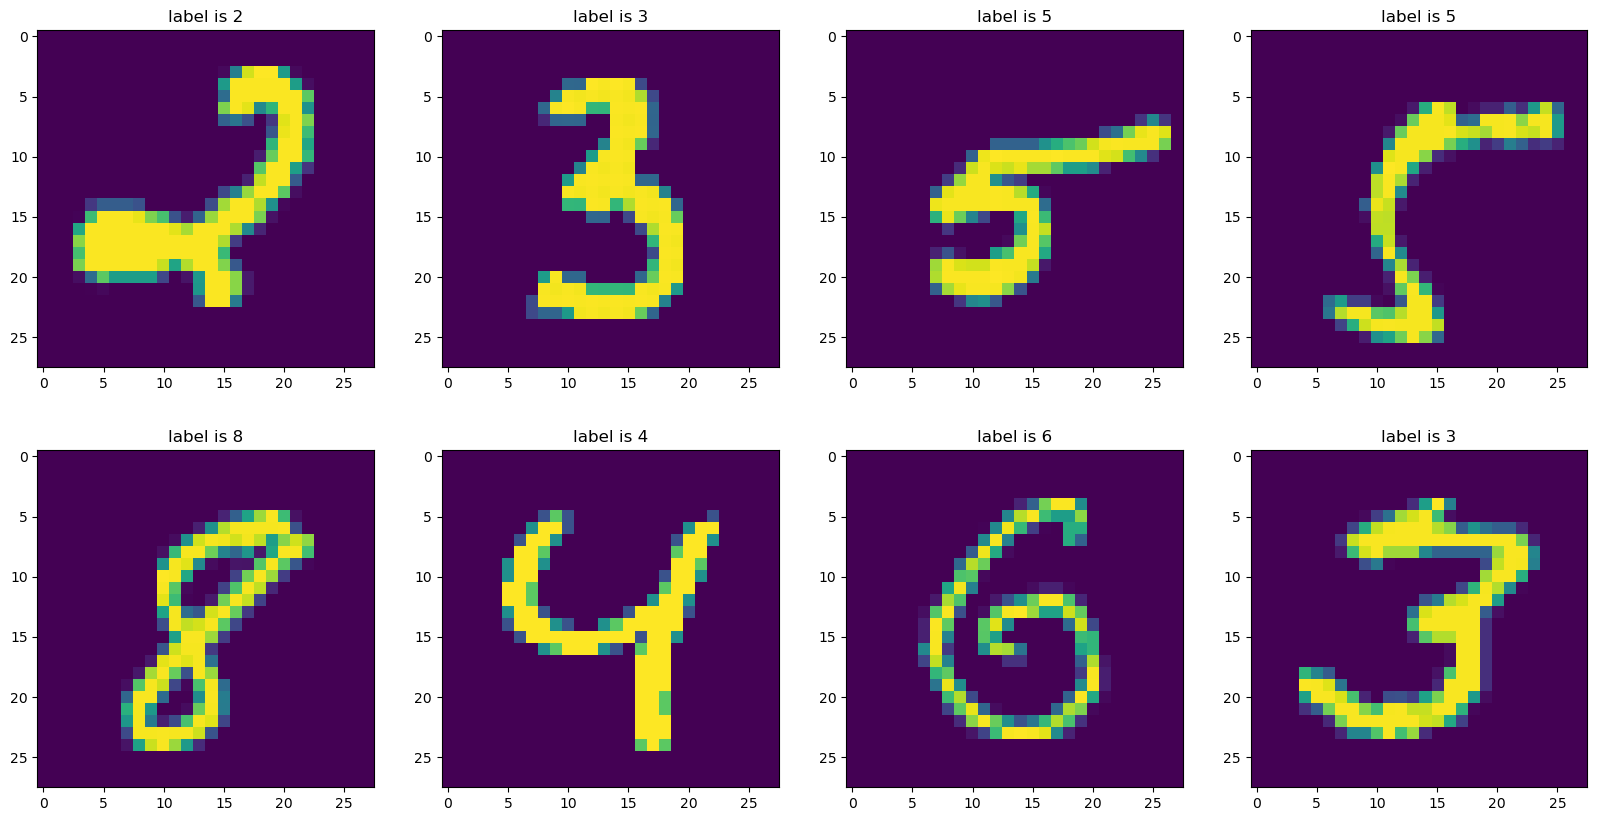

In [2]:
trainX, trainY, testX, testY = load_data()

num_train, num_feature = trainX.shape
plt.figure(1, figsize=(20,10))
for i in range(8):
    idx = np.random.choice(range(num_train))
    plt.subplot(int('24'+str(i+1)))
    plt.imshow(trainX[idx,:].reshape((28,28)))
    plt.title('label is %d'%trainY[idx])
plt.show()

In [3]:
# normalize the input value to make it between 0 and 1.
trainX, testX = trainX/255, testX/255

# convert labels to one-hot vector.
def to_onehot(y):
    y = y.astype(int)
    num_class = len(set(y))
    Y = np.eye((num_class))
    return Y[y]

trainY = to_onehot(trainY)
testY = to_onehot(testY)
num_train, num_feature = trainX.shape
num_test, _ = testX.shape
_, num_class = trainY.shape
print('number of features is %d'%num_feature)
print('number of classes is %d'%num_class)
print('number of training samples is %d'%num_train)
print('number of testing samples is %d'%num_test)
print('shape of training data is ' + str(trainX.shape))
print('shape of training data label is ' + str(trainX.shape))
print('shape of testing data is ' + str(testX.shape))
print('shape of testing data label is ' + str(testX.shape) )

number of features is 784
number of classes is 10
number of training samples is 60000
number of testing samples is 10000
shape of training data is (60000, 784)
shape of training data label is (60000, 784)
shape of testing data is (10000, 784)
shape of testing data label is (10000, 784)


In [4]:
from abc import ABC, abstractmethod, abstractproperty

class Activation(ABC):
    '''
    An abstract class that implements an activation function
    '''
    @abstractmethod
    def value(self, x: np.ndarray) -> np.ndarray:
        '''
        Value of the activation function when input is x.
        Parameters:
          x is an input to the activation function.
        Returns: 
          Value of the activation function. The shape of the return is the same as that of x.
        '''
        return x
    @abstractmethod
    def derivative(self, x: np.ndarray) -> np.ndarray:
        '''
        Derivative of the activation function with input x.
        Parameters:
          x is the input to activation function
        Returns: 
          Derivative of the activation function w.r.t x.
        '''
        return x

class Identity(Activation):
    '''
    Identity activation function. Input and output are identical. 
    '''

    def __init__(self):
        super(Identity, self).__init__()

    def value(self, x: np.ndarray) -> np.ndarray:
        return x
    
    def derivative(self, x: np.ndarray) -> np.ndarray:
        n, m = x.shape
        return np.ones((n, m))
    

class Sigmoid(Activation):
    '''
    Sigmoid activation function y = 1/(1 + e^(-x*k)), where k is the parameter of the sigmoid function 
    '''

    def __init__(self):
        '''
        Parameters:
          there are no parameters.
        '''
        super(Sigmoid, self).__init__()

    def value(self, x: np.ndarray) -> np.ndarray:
        '''
        Parameters:
          x is a two dimensional numpy array.
        Returns:
          a two dimensioal array representing the element-wise sigmoid of x.
        '''
        #### write your code below ####
        return 1 / (1 + np.exp(-x))

    def derivative(self, x: np.ndarray) -> np.ndarray:
        '''
        Parameters:
          x is a two dimensional array.
        Returns:
          a two dimensional array whose shape is the same as that of x. The returned value is the elementwise 
          derivative of the sigmoid function w.r.t. x.
        '''
        #### write your code below ####
        y = self.value(x)
        return y * (1 - y)
    
class ReLU(Activation):
    '''
    Rectified linear unit activation function
    '''

    def __init__(self):
        super(ReLU, self).__init__()

    def value(self, x: np.ndarray) -> np.ndarray:
        #### write your code below ####
        
        return np.maximum(0, x)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        '''
        The derivative of the ReLU function w.r.t. x. Set the derivative to 0 at x=0.
        Parameters:
          x is a two dimensional array.
        Returns:
          elementwise derivative of ReLU. The shape of the returned value is the same as that of x.
        '''
        #### write your code below ####
        
        
        return np.where(x > 0, 1, 0)


class Softmax(Activation):
    '''
    softmax nonlinear function.
    '''

    def __init__(self):
        '''
        There are no parameters in softmax function.
        '''
        super().__init__()

    def value(self, x: np.ndarray) -> np.ndarray:
        '''
        Parameters:
          x is the input to the softmax function. x is a two dimensional numpy array. Each row is the input to the softmax function
        Returns:
          output of the softmax function. The returned value is with the same shape as that of x.
        '''
        # subtract the max of each row to avoid numerical overflow
        x = x - np.max(x, axis=1, keepdims=True)
        # compute the exponential of each element
        exp_x = np.exp(x)
        # compute the sum of exponential along each row
        sum_exp_x = np.sum(exp_x, axis=1, keepdims=True)
        # divide each element by the sum to get the probability
        return exp_x / sum_exp_x

    def derivative(self, x: np.ndarray) -> np.ndarray:
        '''
        Parameters:
          x is the input to the softmax function. x is a two dimensional numpy array.
        Returns:
          a two dimensional array representing the derivative of softmax function w.r.t. x.
        '''
        # compute the value of softmax
        y = self.value(x)
        # compute the diagonal elements of the derivative matrix for each sample in the batch
        dy_dx = np.einsum('ij,ik->ijk', y, np.eye(y.shape[1])) - np.einsum('ij,ik->ijk', y, y.swapaxes(-1, -2))
        # return the diagonal elements as a two-dimensional array
        return dy_dx.sum(axis=-1)

For neural network for multi-class classification, the last layer is usually a softmax activation function. The output of the softmax function together with true targets or labels are used to compute the loss function. If both the softmax function and the loss function are computed independently, there are at least one drawbacks:

> The derivative of the softmax function w.r.t. the input is a matrix, which is not like the elementwise derivative in ReLU or sigmoid. A batch of such derivatives forms a three dimensional tensor, making the computation complicated.

To mitigate such an issue, a common trick is to merge the computation of softmax function with the loss function. In other words, the inputs to the loss function is the input to the softmax other than its output. In deep learning community, often the input to the softmax is regarded as unnormalized probability and is called logits. Being called logits is not exactly correct in math but is widely used. Let $\boldsymbol{z}$ be the logits, the output of the softmax function $\hat{\boldsymbol{y}}$ is defined as

$\hat{y}_i = \frac{e^{z_i}}{\sum_{j=1}^ke^{z_j}}, i = 1, \cdots, k$

the cross entropy loss is computed as follows:

$L(\boldsymbol{z}, \boldsymbol{y}) = \sum_{i=1}^k y_i\log(\hat{y}_i) = \sum_{i=1}^k y_i\log\left(\frac{e^{z_i}}{\sum_{j=1}^ke^{z_j}}\right) = \sum_{i=1}^k y_i z_i - \sum_{i=1}^k y_i\log(\sum_{j=1}^ke^{z_j})= \sum_{i=1}^k y_i z_i - \log(\sum_{j=1}^ke^{z_j})$

In the above expression, there is a log-sum-exponential term, which often appears in research papers and text book. The reason people prefer the log-sum-exponential term is that it is easy to deal with overflow problem. For instance, there is

$L(\boldsymbol{z}, \boldsymbol{y}) = \sum_{i=1}^k y_i z_i - \log(\sum_{j=1}^ke^{z_j}) = \sum_{i=1}^k y_i z_i - \log(\sum_{j=1}^ke^{\beta}e^{-\beta}e^{z_j})= \sum_{i=1}^k y_i z_i -\beta - \log(\sum_{j=1}^ke^{z_j-\beta})$

By letting $\beta = \max z_i$, exponential terms in the exponential expression are all negative, avoiding the overflow problem.

The derivative of the above loss function is computed as follows:

$\frac{\partial L}{\partial z_i} = y_i - \frac{e^{z_i}}{\sum_{j=1}^k e^{z_j}}$
, where the expression $\frac{e^{z_i}}{\sum_{j=1}^k e^{z_j}}$ is exactly the $i$th output of the softmax function. Thus,

$\frac{\partial L}{\partial \boldsymbol{z}} = \boldsymbol{y} - \text{softmax}(\boldsymbol{z})$

In [5]:
##################################################################################################################
# LOSS FUNCTIONS
##################################################################################################################

class Loss(ABC):
    '''
    Abstract class for a loss function
    '''
    @abstractmethod
    def value(self, yhat: np.ndarray, y: np.ndarray) -> float:
        '''
        Value of the empirical loss function.
        Parameters:
          y_hat is the output of a neural network. The shape of y_hat is (n, k). Each row represents the one sample output.
          y contains true labels with shape (n, k).
        Returns:
          value of the empirical loss function.
        '''
        return 0

    @abstractmethod
    def derivative(self, yhat: np.ndarray, y: np.ndarray) -> np.ndarray:
        '''
        Derivative of the empirical loss function with respect to the predictions.
        Parameters:
          
        Returns:
          The derivative of the loss function w.r.t. y_hat. The returned value is a two dimensional array with 
          shape (n, k)
        '''
        return yhat

class CrossEntropy(Loss):
    """
    Cross entropy loss function
    """
    def value(self, yhat: np.ndarray, y: np.ndarray) -> float:
        return -np.sum(y * np.log(yhat)) / yhat.shape[0]

    def derivative(self, yhat: np.ndarray, y: np.ndarray) -> np.ndarray:
        return -(y / yhat) / yhat.shape[0]

class CEwithLogit(Loss):
    """
    Cross entropy loss function with logits (input of softmax activation function) and true labels as inputs.
    """
    def value(self, logits: np.ndarray, y: np.ndarray) -> float:
        max_logits = np.max(logits, axis=1, keepdims=True)
        log_sum_exp = np.log(np.sum(np.exp(logits - max_logits), axis=1, keepdims=True)) + max_logits
        loss = np.sum(log_sum_exp - logits * y) / logits.shape[0]
        return loss

    def derivative(self, logits: np.ndarray, y: np.ndarray) -> np.ndarray:
        max_logits = np.max(logits, axis=1, keepdims=True)
        log_sum_exp = np.log(np.sum(np.exp(logits - max_logits), axis=1, keepdims=True)) + max_logits
        grad = (np.exp(logits - log_sum_exp) - y) / logits.shape[0]
        return grad

In [6]:
##################################################################################################################
# METRICS
##################################################################################################################

def accuracy(y_hat: np.ndarray, y: np.ndarray) -> float:
    '''
    Accuracy of predictions, given the true labels.
    Parameters:
      y_hat is the outputs of softmax function. y_hat is with the shape (n, k).
      y is the true targets. y is with the shape (n, k).
    Returns:
      accuracy which is a float number.
    '''
    # get the predicted class for each sample
    y_pred = np.argmax(y_hat, axis=1)
    # get the true class for each sample
    y_true = np.argmax(y, axis=1)
    # count the number of correct predictions
    num_correct = np.sum(y_pred == y_true)
    # calculate the accuracy as the fraction of correct predictions
    accuracy = num_correct / y.shape[0]
    return accuracy

In [7]:
# The following is the python class for neural network.
# Using this class, users can design a neural network with any number of layers within which there could be any number of neuros

class NeuralNetwork():
    '''
    Fully connected neural network.
    Attributes:
      n_layers is the number of layers.
      activation is a list of Activation objects corresponding to each layer's activation function.
      loss is a Loss object corresponding to the loss function used to train the network.
      learning_rate is the learning rate.
      W is a list of weight matrix used in each layer.
      b is a list of biases used in each layer.
    '''

    def __init__(self, layer_size: List[int], activation: List[Activation], loss: Loss, learning_rate: float = 0.01) -> None:
        '''
        Initializes a NeuralNetwork object
        '''
        assert len(activation) == len(layer_size), \
        "Number of sizes for layers provided does not equal the number of activation"
        self.layer_size = layer_size
        self.num_layer = len(layer_size)
        self.activation = activation
        self.loss = loss
        self.learning_rate = learning_rate
        self.W = []
        self.b = []
        for i in range(self.num_layer-1):
            W = np.random.randn(layer_size[i], layer_size[i+1]) #/ np.sqrt(layer_size[i])
            b = np.random.randn(1, layer_size[i+1])
            self.W.append(W)
            self.b.append(b)
        self.A = []
        self.Z = []

    def forward(self, X: np.ndarray) -> (List[np.ndarray], List[np.ndarray]):
        '''
        Forward pass of the network on a dataset of n examples with m features. Except the first layer, each layer
        computes linear transformation plus a bias followed by a nonlinear transformation.
        Parameters:
          X is the training data with shape (n, m).
        Returns:
          A is a list of numpy data, representing the output of each layer after the first layer. There are 
            self.num_layer numpy arrays in the list and each array is of shape (n, self.layer_size[i]).
          Z is a list of numpy data, representing the input of each layer after the first layer. There are
            self.num_layer numpy arrays in the list and each array is of shape (n, self.layer_size[i]).
        '''
        num_sample = X.shape[0]
        A, Z = [], []
        #### write your code below ####
        A.append(X)
        for i in range(self.num_layer - 1):
            z = np.dot(A[i], self.W[i]) + self.b[i]
            Z.append(z)
            a = self.activation[i].value(z)
            A.append(a)
        self.A = A
        self.Z = Z
        return Z, A

    def backward(self, dLdyhat) -> List[np.ndarray]:
        '''
        Backward pass of the network on a dataset of n examples with m features. The derivatives are computed from 
          the end of the network to the front.
        Parameters:
          dLdyhat is the derivative of the empirical loss w.r.t. yhat which is the output of the neural network.
            dLdyhat is with shape (n, self.layer_size[-1])
        Returns:
          dZ is a list of numpy array. Each numpy array in dZ represents the derivative of the emipirical loss function
            w.r.t. the input of that specific layer. There are self.n_layer arrays in the list and each array is of 
            shape (n, self.layer_size[i])
        '''
        dZ = []
        #### write your code below ####
        dA = [dLdyhat]  # Initialize dA with the derivative of the loss w.r.t. yhat
        for i in range(self.num_layer - 2, -1, -1):
            dz = dA[-1] * self.activation[i].derivative(self.Z[i])
            dZ.append(dz)
            da = np.dot(dz, self.W[i].T)
            dA.append(da)
        dZ = dZ[::-1]
        self.dW = [np.dot(self.A[i].T, dZ[i])/num_sample for i in range(self.num_layer - 1)]
        self.db = [np.mean(dZ[i], axis=0, keepdims=True) for i in range(self.num_layer - 1)]
        self.dZ = dZ
        return dZ

    def update_weights(self) -> List[np.ndarray]:
        '''
        Having computed the delta values from the backward pass, update each weight with the sum over the training
        examples of the gradient of the loss with respect to the weight.
        Parameters:
          there is no input parameters
        Returns:
          W is the newly updated weights (i.e. self.W)
        '''
        #### write your code below ####
        for i in range(self.num_layer-1):
            self.W[i] -= self.learning_rate * self.dW[i]
            self.b[i] -= self.learning_rate * self.db[i]
        return self.W
    
    def one_epoch(self, X: np.ndarray,  Y: np.ndarray, batch_size: int, train: bool = True) -> (float, float):
        '''
        One epoch of either training or testing procedure.
        Parameters:
          X is the data input. X is a two dimensional numpy array.
          Y is the data label. Y is a one dimensional numpy array.
          batch_size is the number of samples in each batch.
          train is a boolean value indicating training or testing procedure.
        Returns:
          loss_value is the average loss function value.
          acc_value is the prediction accuracy. 
        '''
        n = X.shape[0]
        slices = list(gen_batches(n, batch_size))
        num_batch = len(slices)
        idx = list(range(n))
        np.random.shuffle(idx)
        loss_value, acc_value = 0, 0
        for i, index in enumerate(slices):
            index = idx[slices[i]]
            x, y = X[index,:], Y[index]
            Z, A = self.forward(x)   # Execute forward pass
            yhat = A[-1]
            if train:
                dLdyhat = self.loss.derivative(yhat, y)   # Calculate derivative of the loss with respect to yhat
                self.backward(dLdyhat)     # Execute the backward pass to compute the deltas
                self.update_weights()  # Calculate the gradients and update the weights
            loss_value += self.loss.value(yhat, y)*x.shape[0]
            acc_value += accuracy(yhat, y)*x.shape[0]
        loss_value = loss_value/n
        acc_value = acc_value/n
        return loss_value, acc_value

In [8]:
def train(model : NeuralNetwork, X: np.ndarray, Y: np.ndarray, batch_size: int, epoches: int) -> (List[np.ndarray], List[float]):
    '''
    trains the neural network.
    Parameters:
      model is a NeuralNetwork object.
      X is the data input. X is a two dimensional numpy array.
      Y is the data label. Y is a one dimensional numpy array.
      batch_size is the number of samples in each batch.
      epoches is an integer, representing the number of epoches.
    Returns:
      epoch_loss is a list of float numbers, representing loss function value in all epoches.
      epoch_acc is a list of float numbers, representing the accuracies in all epoches.
    '''
    loss_value, acc = model.one_epoch(X, Y, batch_size, train = False)
    epoch_loss, epoch_acc = [loss_value], [acc]
    print('Initialization: ', 'loss %.4f  '%loss_value, 'accuracy %.2f'%acc)
    for epoch in range(epoches):
        if epoch%100 == 0 and epoch > 0: # decrease the learning rate
            model.learning_rate = min(model.learning_rate/10, 1.0e-5)
        loss_value, acc = model.one_epoch(X, Y, batch_size, train = True)
        if epoch%1 == 0:
            print("Epoch {}/{}: Loss={}, Accuracy={}".format(epoch, epoches, loss_value, acc))
        epoch_loss.append(loss_value)
        epoch_acc.append(acc)
    return epoch_loss, epoch_acc

In [9]:
# training procedure
num_sample, num_feature = trainX.shape
epoches = 10
batch_size = 512
Loss = []
Acc = []
learning_rate = 1/num_sample*batch_size
np.random.seed(2023)
model = NeuralNetwork([784, 256, 64, 10], [Identity(), ReLU(), ReLU(), Softmax()], CEwithLogit(), learning_rate = learning_rate)
epoch_loss, epoch_acc = train(model, trainX, trainY, batch_size, epoches)
# testing procedure
test_loss, test_acc = model.one_epoch(testX, testY, batch_size, train = False)
z, yhat = model.forward(testX)
yhat = yhat[-1]
yhat = np.argmax(yhat, axis = 1)
y = np.argmax(testY, axis = 1)
print(confusion_matrix(yhat, y))
print(classification_report(yhat, y))

Initialization:  loss 10107.1653   accuracy 0.11
Epoch 0/10: Loss=10085.406491419459, Accuracy=0.11131666666666666
Epoch 1/10: Loss=10040.951098624377, Accuracy=0.11146666666666667
Epoch 2/10: Loss=9997.116389769675, Accuracy=0.11171666666666667
Epoch 3/10: Loss=9953.634873838013, Accuracy=0.11163333333333333
Epoch 4/10: Loss=9910.91279735154, Accuracy=0.11156666666666666
Epoch 5/10: Loss=9868.546923883949, Accuracy=0.11143333333333333
Epoch 6/10: Loss=9826.572866358121, Accuracy=0.11126666666666667
Epoch 7/10: Loss=9785.12264066661, Accuracy=0.11135
Epoch 8/10: Loss=9744.133646880366, Accuracy=0.11125
Epoch 9/10: Loss=9703.715127167154, Accuracy=0.11146666666666667
[[  3   5 115  12  35   6   8 102  10  15]
 [ 59  32  24   7  85  48  25  55  13  72]
 [  0  21   4   0  28   5  11  30   3  25]
 [200 548 160 500 344 343 448 309 283 575]
 [545 321 385 232 206 224 342 162 395 197]
 [  0   9  11   1   0   0   2   7   0   1]
 [  2  26  13   9   3   9  13   0   6   0]
 [ 79 111  96 139 147 16